In [1]:
######################## PetFinder Malaysia Modeling ##############################

#author: Zoë Kimpel
#date: 4.25.19

#libraries
import sys
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn import tree
import collections
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

plt.style.use('bmh')
%matplotlib inline

C:\Users\sadeeb\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [3]:
#import the dataset

pet = pd.read_csv('train_features_w_state_info.csv', sep = ',')

pet.describe()

,Type,Age,Age_Yr,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,State,VideoAmt,PhotoAmt,AdoptionSpeed,Population,TotalArea(km2),HDI,Population_Density,2017GDPpercapita_USD,2017GDPpercapita_RM
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,...,14993.000000,14993.000000,14993.000000,14993.000000,1.499300e+04,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457547,10.452078,0.651637,265.287267,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,...,41346.028347,0.056760,3.889215,2.516441,4.212681e+06,6726.458747,0.814669,2395.926644,15818.693991,62912.072634
std,0.498211,18.155790,1.558780,60.024977,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,...,32.444153,0.346185,3.487810,1.177265,1.991900e+06,6973.628714,0.013912,2878.851275,7254.001448,28848.942564
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,41324.000000,0.000000,0.000000,0.000000,9.680000e+04,91.000000,0.674000,21.181197,3417.000000,13593.000000
25%,1.000000,2.000000,0.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,...,41326.000000,0.000000,2.000000,2.000000,1.768000e+06,243.000000,0.819000,724.839585,12092.000000,48091.000000
50%,1.000000,3.000000,0.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,41326.000000,0.000000,3.000000,2.000000,5.874100e+06,8104.000000,0.819000,724.839585,12092.000000,48091.000000
75%,2.000000,12.000000,1.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,...,41401.000000,0.000000,5.000000,4.000000,5.874100e+06,8104.000000,0.822000,7275.720165,27991.000000,111321.000000
max,2.000000,255.000000,21.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,...,41415.000000,8.000000,30.000000,4.000000,5.874100e+06,124450.000000,0.822000,7275.720165,27991.000000,111321.000000


In [4]:
#check for missing
#% of columns that are NA
columns = pet.columns
percent_missing = pet.isnull().sum() * 100 / len(pet)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

#name is missing - remove column from final training set

,column_name,percent_missing
Type,Type,0.000000
Sterilized,Sterilized,0.000000
Sterilized_Name,Sterilized_Name,0.000000
Health,Health,0.000000
Health_Name,Health_Name,0.000000
Quantity,Quantity,0.000000
Fee,Fee,0.000000
State,State,0.000000
State_Label,State_Label,0.000000
RescuerID,RescuerID,0.000000


In [5]:
###################### Modeling ######################

#dataprep

#split into X & Y
X_features = ['Type', 'Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt','Population',
             'TotalArea(km2)','HDI', 'Population_Density', 'Dewormed', '2017GDPpercapita_USD', 'Vaccinated', 'Age', 'Breed1', 'Breed2',
             'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength']
X = pet[X_features]
X.replace(' ', '')
Y = pet['AdoptionSpeed']
Y = Y.astype('int')

#split data into test and train
validation_size = .2
random_seed = 1234

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = validation_size, random_state = random_seed)


In [6]:
X.dtypes

Type                      int64
Sterilized                int64
Health                    int64
Fee                       int64
VideoAmt                  int64
PhotoAmt                  int64
Population                int64
TotalArea(km2)            int64
HDI                     float64
Population_Density      float64
Dewormed                  int64
2017GDPpercapita_USD      int64
Vaccinated                int64
Age                       int64
Breed1                    int64
Breed2                    int64
Gender                    int64
Color1                    int64
Color2                    int64
Color3                    int64
MaturitySize              int64
FurLength                 int64
dtype: object

In [7]:
# 3 basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = random_seed) #10 fold cross validation
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = ("Model:", name, cv_results.mean())
    print(msg)

('Model:', 'LR', 0.2970651932165694)
('Model:', 'CART', 0.33174847094801224)
('Model:', 'NB', 0.2938144981929386)


In [8]:
# looking at Decision Tree Classifier
DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)
predictions_DT = DT.predict(x_test)
print("done")


#how accuracy is it?
print("Accuracy Score \n", accuracy_score(y_test, predictions_DT))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, predictions_DT))
print("Classification Report", "\n", classification_report(y_test, predictions_DT))

done
Accuracy Score 
 0.32477492497499166
Confusion Matrix 
 [[  7  26  13  15  20]
 [ 16 153 191 107 125]
 [ 28 166 258 177 177]
 [ 22 124 155 189 153]
 [ 19 120 192 179 367]]
Classification Report 
              precision    recall  f1-score   support

          0       0.08      0.09      0.08        81
          1       0.26      0.26      0.26       592
          2       0.32      0.32      0.32       806
          3       0.28      0.29      0.29       643
          4       0.44      0.42      0.43       877

avg / total       0.33      0.32      0.33      2999



In [9]:
#train the algorithm

RF = RandomForestClassifier(n_estimators = 100,
                                    max_features = 'log2',
                                    bootstrap = False,
                                    random_state = random_seed)
RF.fit(x_train, y_train)
y_pred_RF = RF.predict(x_test)

#how accuracy is it?
print("Quadratic Weighted Kappa Score \n", quadratic_weighted_kappa(y_test, y_pred_RF))
print("Accuracy Score \n", accuracy_score(y_test, y_pred_RF))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, y_pred_RF))
print("Classification Report", "\n", classification_report(y_test, y_pred_RF))

Quadratic Weighted Kappa Score 
 0.3421876830598276
Accuracy Score 
 0.40546848949649883
Confusion Matrix 
 [[  8  24  21   9  19]
 [  7 208 175  84 118]
 [ 10 188 298 130 180]
 [  3 103 182 188 167]
 [  4  70 171 118 514]]
Classification Report 
              precision    recall  f1-score   support

          0       0.25      0.10      0.14        81
          1       0.35      0.35      0.35       592
          2       0.35      0.37      0.36       806
          3       0.36      0.29      0.32       643
          4       0.52      0.59      0.55       877

avg / total       0.40      0.41      0.40      2999



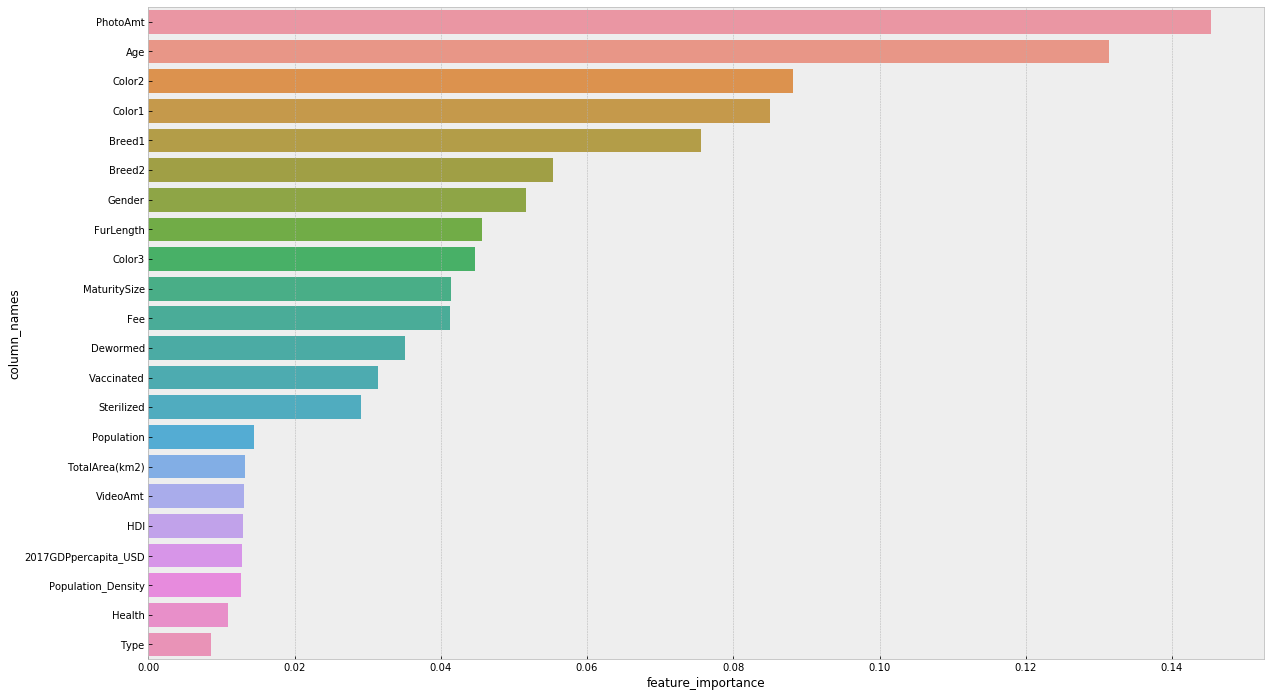

In [13]:
RF_feature_importance_df = pd.DataFrame({"column_names":x_train.columns, "feature_importance": RF.feature_importances_})
RF_feature_importance_df = RF_feature_importance_df.sort_values('feature_importance',ascending=False)
#xgb_feature_importance_filtered_df = RF_feature_importance_df.loc[RF_feature_importance_df.feature_importance>0.003].sort_values('feature_importance',ascending=False)
f, ax = plt.subplots(figsize=(20, 12))
sns.barplot(x="feature_importance", y="column_names", data=RF_feature_importance_df)

In [12]:
#print the feature importances
print("Features sorted by their score:\n")
print(sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), X_features), reverse=True))

Features sorted by their score:

[(0.1454, 'PhotoAmt'), (0.1314, 'Age'), (0.0881, 'Color2'), (0.085, 'Color1'), (0.0756, 'Breed1'), (0.0554, 'Breed2'), (0.0517, 'Gender'), (0.0457, 'FurLength'), (0.0447, 'Color3'), (0.0414, 'MaturitySize'), (0.0413, 'Fee'), (0.0352, 'Dewormed'), (0.0315, 'Vaccinated'), (0.0291, 'Sterilized'), (0.0144, 'Population'), (0.0132, 'TotalArea(km2)'), (0.0131, 'VideoAmt'), (0.013, 'HDI'), (0.0128, '2017GDPpercapita_USD'), (0.0127, 'Population_Density'), (0.0109, 'Health'), (0.0086, 'Type')]


In [18]:
#separate into cat vs. dog specific models

dog = pet[pet['Type_Name'] == 'Dog']
cat = pet[pet['Type_Name'] == 'Cat']

cat.head()


,Type,Type_Name,Name,Age,Age_Yr,Breed1,Breed1_Name,Breed2,Breed2_Name,Gender,...,PhotoAmt,AdoptionSpeed,StateorTerritory,Population,TotalArea(km2),Region,HDI,Population_Density,2017GDPpercapita_USD,2017GDPpercapita_RM
0,2,Cat,Nibble,3,0,299,Tabby,0,0,1,...,1,2,State,5874100,8104,West_Malaysia,0.819,724.839585,12092,48091
1,2,Cat,No Name Yet,1,0,265,Domestic Medium Hair,0,0,1,...,2,0,Territory,1768000,243,West_Malaysia,0.822,7275.720165,27991,111321
5,2,Cat,NaN,3,0,266,Domestic Short Hair,0,0,2,...,2,2,State,5874100,8104,West_Malaysia,0.819,724.839585,12092,48091
6,2,Cat,BULAT,12,1,264,Domestic Long Hair,264,Domestic Long Hair,1,...,3,1,State,5874100,8104,West_Malaysia,0.819,724.839585,12092,48091
8,2,Cat,NaN,2,0,265,Domestic Medium Hair,0,0,2,...,6,1,State,5874100,8104,West_Malaysia,0.819,724.839585,12092,48091


In [19]:
########## dog

###################### Modeling ######################

#dataprep

#split into X & Y
X_features = ['Type', 'Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt','Population',
             'TotalArea(km2)','HDI', 'Population_Density', 'Dewormed', '2017GDPpercapita_USD', 'Vaccinated', 'Age', 'Breed1', 'Breed2',
             'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength']
X_dog = dog[X_features]
X_dog.replace(' ', '')
Y_dog = dog['AdoptionSpeed']
Y_dog = Y_dog.astype('int')

#split data into test and train
validation_size = .2
random_seed = 1234

x_train_dog, x_test_dog, y_train_dog, y_test_dog = model_selection.train_test_split(X_dog, Y_dog, test_size = validation_size, random_state = random_seed)


#train the algorithm

RF_dog = RandomForestClassifier(n_estimators = 100,
                                    max_features = 'log2',
                                    bootstrap = False,
                                    random_state = random_seed)
RF_dog.fit(x_train_dog, y_train_dog)
y_pred_RF_dog = RF_dog.predict(x_test_dog)

#how accuracy is it?
print("Accuracy Score \n", accuracy_score(y_test_dog, y_pred_RF_dog))
print("Confusion Matrix", "\n",  confusion_matrix(y_test_dog, y_pred_RF_dog))
print("Classification Report", "\n", classification_report(y_test_dog, y_pred_RF_dog))


#print the feature importances
print("Features sorted by their score:\n")
print(sorted(zip(map(lambda x: round(x, 4), RF_dog.feature_importances_), X_features), reverse=True))


Accuracy Score 
 0.42593730792870316
Confusion Matrix 
 [[  1  12  11   7   9]
 [  4 100  74  40  55]
 [  5  75 153 106 109]
 [  2  52  87 144 103]
 [  3  37  67  76 295]]
Classification Report 
              precision    recall  f1-score   support

          0       0.07      0.03      0.04        40
          1       0.36      0.37      0.36       273
          2       0.39      0.34      0.36       448
          3       0.39      0.37      0.38       388
          4       0.52      0.62      0.56       478

avg / total       0.41      0.43      0.42      1627

Features sorted by their score:

[(0.1526, 'PhotoAmt'), (0.1407, 'Age'), (0.0859, 'Color2'), (0.0831, 'Color1'), (0.0636, 'Breed1'), (0.0564, 'Breed2'), (0.0498, 'Gender'), (0.0459, 'FurLength'), (0.0425, 'Color3'), (0.0413, 'MaturitySize'), (0.0396, 'Fee'), (0.0368, 'Dewormed'), (0.0365, 'Vaccinated'), (0.0363, 'Sterilized'), (0.0152, 'Population'), (0.0133, 'TotalArea(km2)'), (0.0127, 'Population_Density'), (0.0127, 'HDI'), 

In [20]:
########## cat

###################### Modeling ######################

#dataprep

#split into X & Y
X_features = ['Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt','Population',
             'TotalArea(km2)','HDI', 'Population_Density', 'Dewormed', '2017GDPpercapita_USD', 'Vaccinated', 'Age', 'Breed1', 'Breed2',
             'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength']
X_cat = cat[X_features]
X_cat.replace(' ', '')
Y_cat = cat['AdoptionSpeed']
Y_cat = Y_cat.astype('int')

#split data into test and train
validation_size = .2
random_seed = 1234

x_train_cat, x_test_cat, y_train_cat, y_test_cat = model_selection.train_test_split(X_cat, Y_cat, test_size = validation_size, random_state = random_seed)


#train the algorithm

RF_cat = RandomForestClassifier(n_estimators = 100,
                                    max_features = 'log2',
                                    bootstrap = False,
                                    random_state = random_seed)
RF_cat.fit(x_train_cat, y_train_cat)
y_pred_RF_cat = RF_cat.predict(x_test_cat)

#how accuracy is it?
print("Accuracy Score \n", accuracy_score(y_test_cat, y_pred_RF_cat))
print("Confusion Matrix", "\n",  confusion_matrix(y_test_cat, y_pred_RF_cat))
print("Classification Report", "\n", classification_report(y_test_cat, y_pred_RF_cat))


#print the feature importances
print("Features sorted by their score:\n")
print(sorted(zip(map(lambda x: round(x, 4), RF_cat.feature_importances_), X_features), reverse=True))


Accuracy Score 
 0.37755102040816324
Confusion Matrix 
 [[  4  10  10   4  12]
 [  5 114 107  47  62]
 [  6  87 145  54  73]
 [  3  56  81  49  69]
 [  1  62  68  37 206]]
Classification Report 
              precision    recall  f1-score   support

          0       0.21      0.10      0.14        40
          1       0.35      0.34      0.34       335
          2       0.35      0.40      0.37       365
          3       0.26      0.19      0.22       258
          4       0.49      0.55      0.52       374

avg / total       0.37      0.38      0.37      1372

Features sorted by their score:

[(0.1458, 'PhotoAmt'), (0.1282, 'Age'), (0.0881, 'Color2'), (0.0833, 'Color1'), (0.0824, 'Breed1'), (0.0611, 'Gender'), (0.0558, 'Breed2'), (0.0486, 'Color3'), (0.0471, 'MaturitySize'), (0.0427, 'Fee'), (0.0423, 'FurLength'), (0.031, 'Dewormed'), (0.0273, 'Sterilized'), (0.0249, 'Vaccinated'), (0.0145, 'Population'), (0.0136, 'Population_Density'), (0.0134, 'HDI'), (0.0132, 'TotalArea(km2)'), (

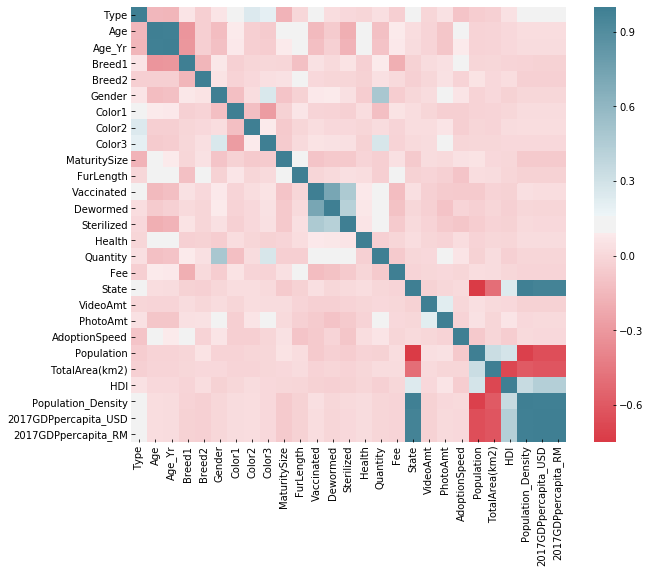

In [21]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = pet.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True),
            square=True, ax=ax)